In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
import pickle
import os
import sys
import copy

pp_path = os.path.dirname(os.path.dirname(os.path.abspath('__file__')))
sys.path.append(pp_path)
os.environ["PYTHONPATH"] = pp_path + ":" + os.environ.get("PYTHONPATH", "")
from utils import *
pd.options.mode.chained_assignment = None # None / 'warn'
pd.set_option('display.max_columns', None)

In [2]:
### read dataset

# source: https://www.kaggle.com/datasets/nishan192/letterrecognition-using-svm
datapath = '../data_raw/Letter/letter-recognition.csv'
df = pd.read_csv(datapath)
df

,letter,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,T,2,8,3,5,1,8,13,0,6,6,10,8,0,8,0,8
1,I,5,12,3,7,2,10,5,5,4,13,3,9,2,8,4,10
2,D,4,11,6,8,6,10,6,2,6,10,3,7,3,7,3,9
3,N,7,11,6,6,3,5,9,4,6,4,4,10,6,10,2,8
4,G,2,1,3,1,1,8,6,6,6,6,5,9,1,7,5,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,D,2,2,3,3,2,7,7,7,6,6,6,4,2,8,3,7
19996,C,7,10,8,8,4,4,8,6,9,12,9,13,2,9,3,7
19997,T,6,9,6,7,5,6,11,3,7,11,9,5,2,12,2,4
19998,S,2,3,4,2,1,8,7,2,6,10,6,8,1,9,5,8


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 17 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   letter  20000 non-null  object
 1   xbox    20000 non-null  int64 
 2   ybox    20000 non-null  int64 
 3   width   20000 non-null  int64 
 4   height  20000 non-null  int64 
 5   onpix   20000 non-null  int64 
 6   xbar    20000 non-null  int64 
 7   ybar    20000 non-null  int64 
 8   x2bar   20000 non-null  int64 
 9   y2bar   20000 non-null  int64 
 10  xybar   20000 non-null  int64 
 11  x2ybar  20000 non-null  int64 
 12  xy2bar  20000 non-null  int64 
 13  xedge   20000 non-null  int64 
 14  xedgey  20000 non-null  int64 
 15  yedge   20000 non-null  int64 
 16  yedgex  20000 non-null  int64 
dtypes: int64(16), object(1)
memory usage: 2.6+ MB


In [4]:
# check for missing values

df.isnull().sum().sum()

0

In [5]:
### preprocessing columns

# assign the column name of the target feature as "Target"
df.rename(columns={"letter":"Target"}, inplace=True)

# make sure the label ranges from 0 to (num_class-1)
df["Target"] = LabelEncoder().fit_transform(df["Target"])

print('\ndata shape: ', df.shape, sep='')
print('\ncolumn names:\n', list(df.columns), sep='')
print('\nclass distribution:\n', df.Target.value_counts(), sep='')
print('\ncolumn types:\n', df.dtypes, sep='')


data shape: (20000, 17)

column names:
['Target', 'xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ', 'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ', 'xedgey', 'yedge ', 'yedgex']

class distribution:
20    813
3     805
15    803
19    796
12    792
0     789
23    787
24    786
16    783
13    783
5     775
6     773
4     768
1     766
21    764
11    761
17    758
8     755
14    753
22    752
18    748
9     747
10    739
2     736
7     734
25    734
Name: Target, dtype: int64

column types:
Target    int64
xbox      int64
ybox      int64
width     int64
height    int64
onpix     int64
xbar      int64
ybar      int64
x2bar     int64
y2bar     int64
xybar     int64
x2ybar    int64
xy2bar    int64
xedge     int64
xedgey    int64
yedge     int64
yedgex    int64
dtype: object


In [6]:
categorical_features = [] ###
continuous_features = list(OrderedSet(df.columns.to_list()) - OrderedSet(["Target"]) - OrderedSet(categorical_features))
print('continuous_features:', continuous_features)
print('\ncategorical_features:', categorical_features)

continuous_features: ['xbox ', 'ybox ', 'width ', 'height', 'onpix ', 'xbar ', 'ybar ', 'x2bar', 'y2bar ', 'xybar ', 'x2ybar', 'xy2bar', 'xedge ', 'xedgey', 'yedge ', 'yedgex']

categorical_features: []


In [7]:
df.describe(include='all')

,Target,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
count,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000,20000.000000,20000.000000,20000.000000,20000.000000,20000.00000
mean,12.516750,4.023550,7.035500,5.121850,5.37245,3.505850,6.897600,7.500450,4.628600,5.178650,8.282050,6.45400,7.929000,3.046100,8.338850,3.691750,7.80120
std,7.502175,1.913212,3.304555,2.014573,2.26139,2.190458,2.026035,2.325354,2.699968,2.380823,2.488475,2.63107,2.080619,2.332541,1.546722,2.567073,1.61747
min,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,6.000000,3.000000,5.000000,4.000000,4.00000,2.000000,6.000000,6.000000,3.000000,4.000000,7.000000,5.00000,7.000000,1.000000,8.000000,2.000000,7.00000
50%,13.000000,4.000000,7.000000,5.000000,6.00000,3.000000,7.000000,7.000000,4.000000,5.000000,8.000000,6.00000,8.000000,3.000000,8.000000,3.000000,8.00000
75%,19.000000,5.000000,9.000000,6.000000,7.00000,5.000000,8.000000,9.000000,6.000000,7.000000,10.000000,8.00000,9.000000,4.000000,9.000000,5.000000,9.00000
max,25.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.00000,15.000000,15.000000,15.000000,15.000000,15.00000


In [8]:
# shuffle and split data into train/(val)/test
seed = 0

train_fraction = 0.75 ###
df_train, df_test = shuffle_split_data(df, train_fraction, seed=seed)

print('train:', df_train.shape)
print(np.unique(df_train.Target, return_counts=True))
print('\ntest:', df_test.shape)
print(np.unique(df_test.Target, return_counts=True))

train: (15000, 17)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25]), array([592, 574, 552, 604, 576, 581, 580, 551, 566, 560, 554, 571, 594,
       587, 565, 602, 587, 568, 561, 597, 610, 573, 564, 590, 590, 551]))

test: (5000, 17)
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25]), array([197, 192, 184, 201, 192, 194, 193, 183, 189, 187, 185, 190, 198,
       196, 188, 201, 196, 190, 187, 199, 203, 191, 188, 197, 196, 183]))


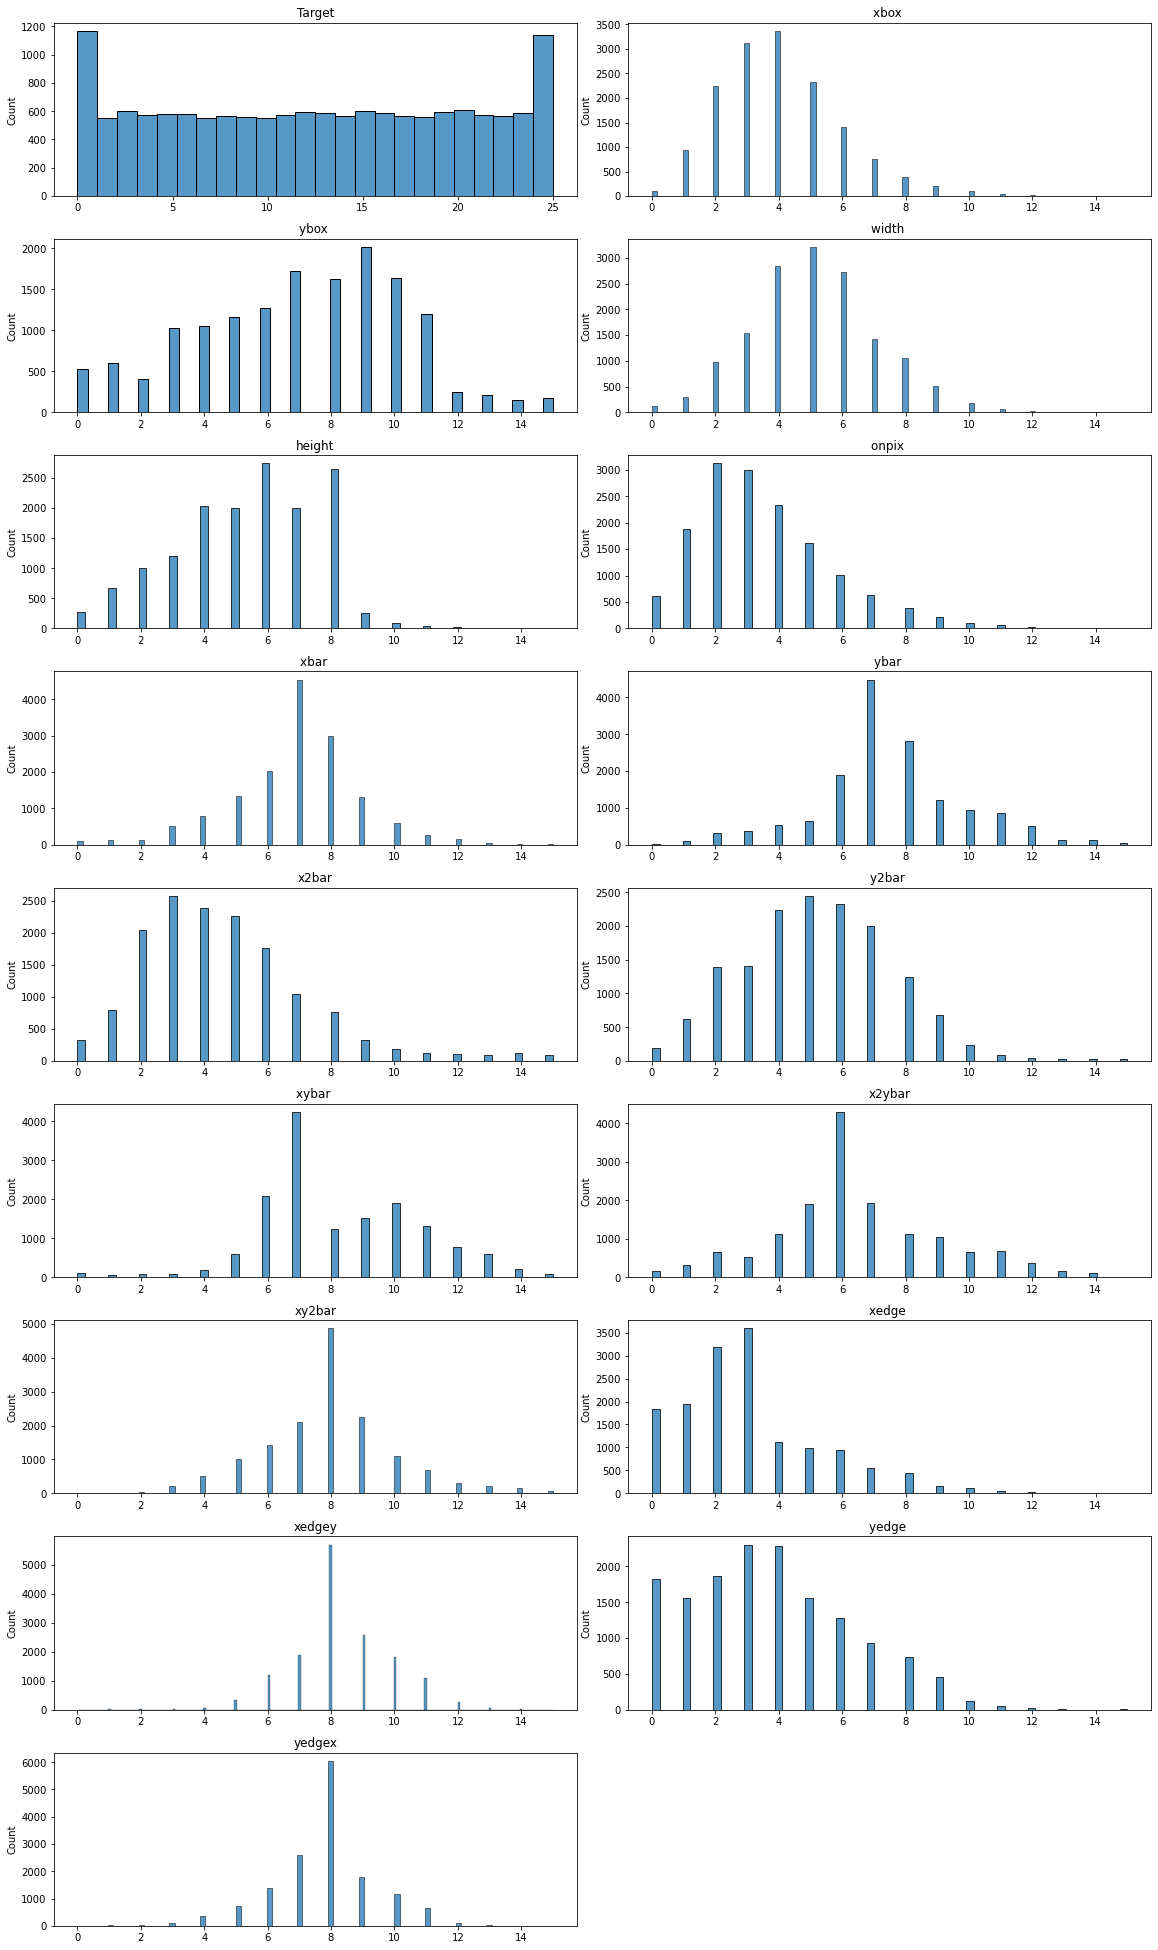

In [9]:
# plot histograms of the training data

ncol, nrow = 2, int(np.ceil(len(df_train.columns)/2))
figsize = (16,3*nrow)

plot_hist(df_train, figsize, nrow, ncol)

In [10]:
# scaling

for feature in continuous_features:
    lower = np.percentile(df_train[feature], 1)
    upper = np.percentile(df_train[feature], 99)

    df_train.loc[df_train[feature]<lower, feature] = lower
    df_train.loc[df_train[feature]>upper, feature] = upper
    df_test.loc[df_test[feature]<lower, feature] = lower
    df_test.loc[df_test[feature]>upper, feature] = upper

scaler_list = [MinMaxScaler(clip=True), MinMaxScaler(clip=True)]   ### StandardScaler() / MinMaxScaler(clip=True)
feature_list = [continuous_features, categorical_features]
df_train_scaled, df_test_scaled = scale_features(df_train, df_test, feature_list, scaler_list)

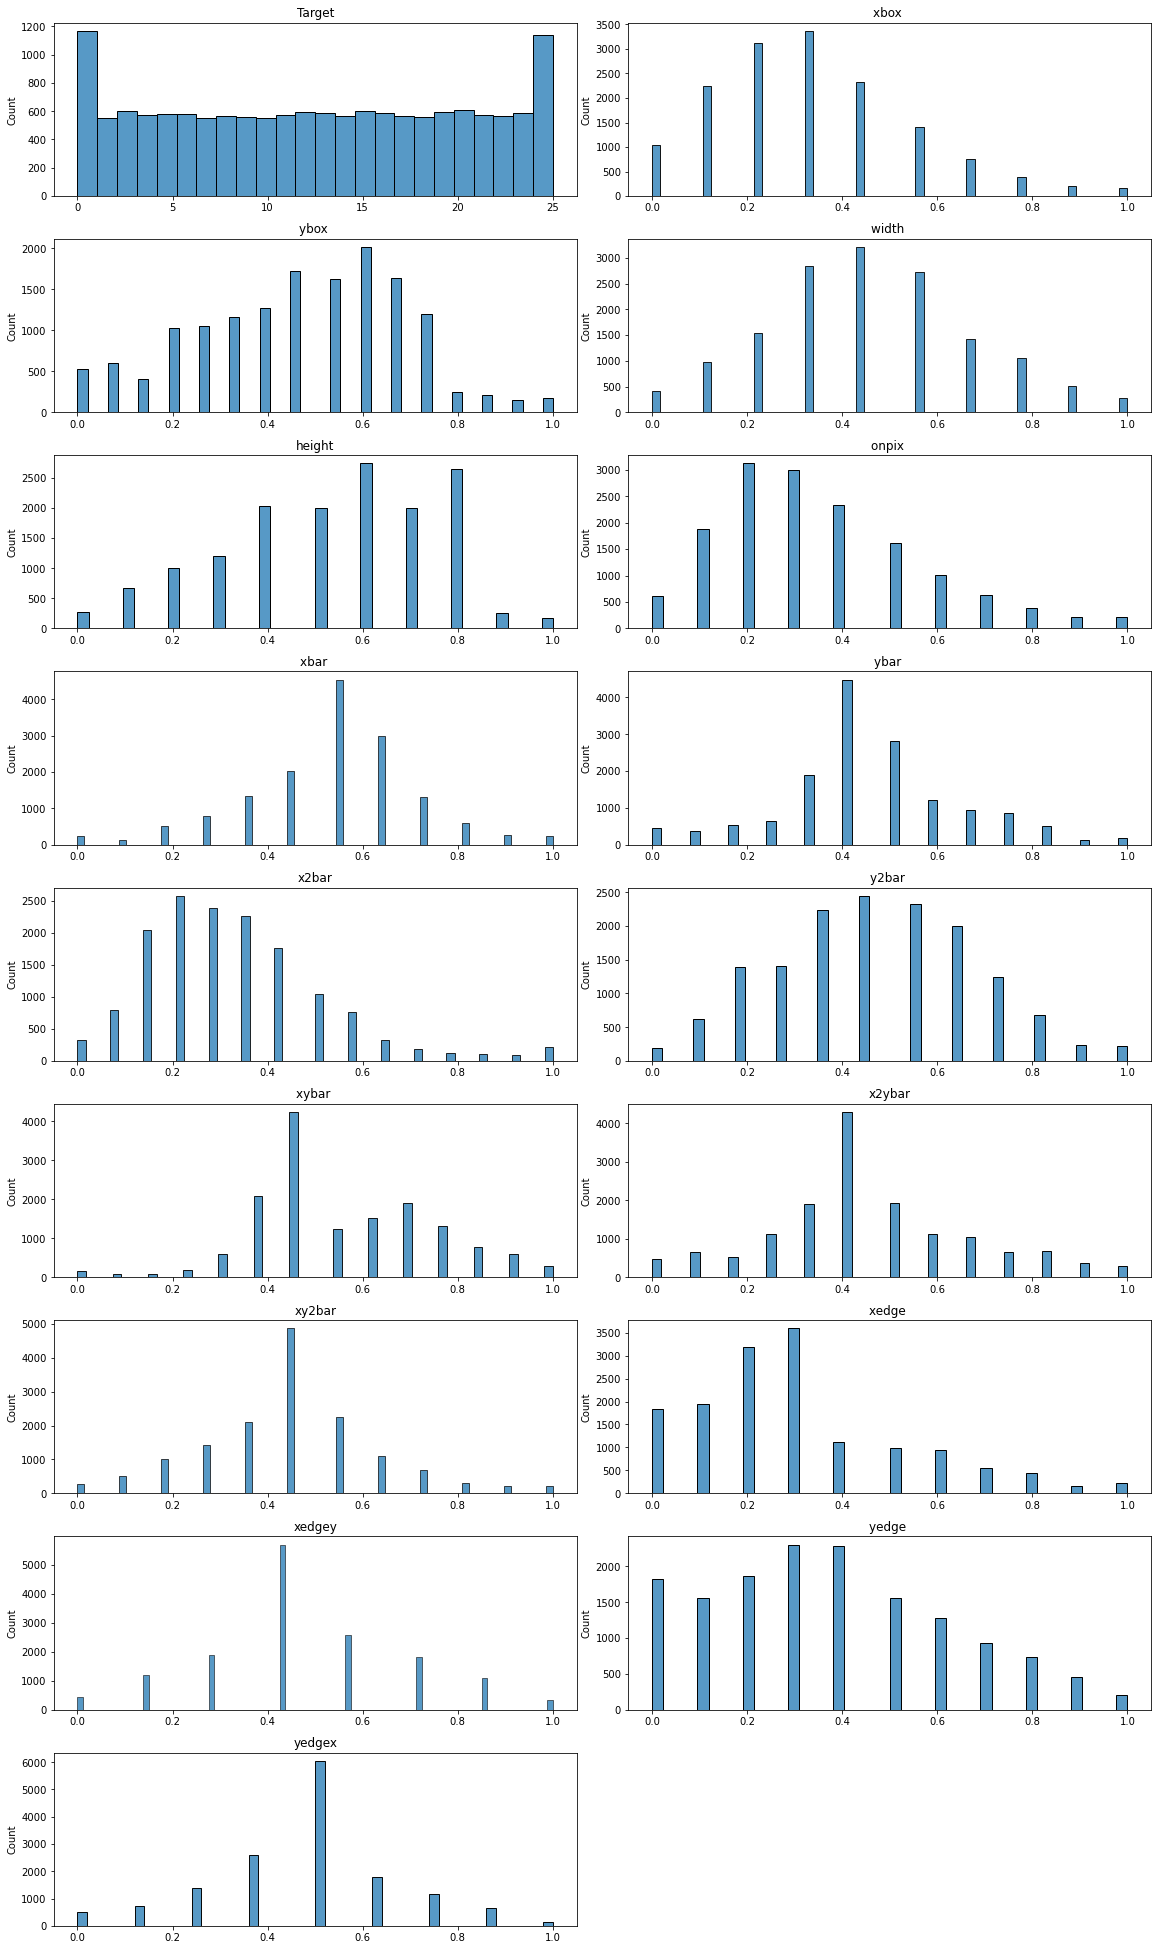

In [11]:
plot_hist(df_train_scaled, figsize, nrow, ncol)

In [12]:
df_train_scaled

,Target,xbox,ybox,width,height,onpix,xbar,ybar,x2bar,y2bar,xybar,x2ybar,xy2bar,xedge,xedgey,yedge,yedgex
0,23,0.111111,0.266667,0.333333,0.3,0.2,0.545455,0.500000,0.071429,0.727273,0.692308,0.416667,0.454545,0.2,0.428571,0.3,0.375
1,8,0.000000,0.266667,0.111111,0.2,0.1,0.545455,0.416667,0.071429,0.636364,0.923077,0.416667,0.454545,0.0,0.428571,0.1,0.500
2,13,0.111111,0.133333,0.222222,0.3,0.2,0.545455,0.500000,0.357143,0.363636,0.461538,0.416667,0.363636,0.4,0.428571,0.1,0.375
3,16,0.222222,0.200000,0.333333,0.5,0.3,0.636364,0.500000,0.428571,0.181818,0.307692,0.500000,0.545455,0.3,0.428571,0.5,0.625
4,11,0.222222,0.733333,0.444444,0.8,0.4,0.181818,0.250000,0.142857,0.727273,0.153846,0.000000,0.545455,0.0,0.285714,0.1,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,18,0.222222,0.600000,0.333333,0.7,0.2,0.545455,0.416667,0.428571,0.727273,0.307692,0.416667,0.363636,0.0,0.428571,0.9,0.375
14996,25,0.666667,0.466667,0.444444,1.0,0.5,0.727273,0.166667,0.285714,0.272727,0.769231,0.416667,0.545455,0.3,0.571429,1.0,0.500
14997,24,0.333333,0.466667,0.555556,1.0,1.0,0.636364,0.250000,0.285714,0.181818,0.538462,0.583333,0.545455,0.5,0.571429,0.6,0.500
14998,7,0.444444,0.666667,0.555556,0.7,0.3,0.545455,0.416667,1.000000,0.000000,0.461538,0.416667,0.454545,0.3,0.428571,0.0,0.500
